# Implementation of GalFlow convolutions

Through an example

- Galaxy image, stamp size of 64 pixels
- PSF image, stamp size of ? pixels

In [1]:
%pylab inline
import tensorflow as tf
import galflow
lp = galflow.lightprofiles

import math
_pi = math.pi

import galsim

Populating the interactive namespace from numpy and matplotlib


(56, 56)


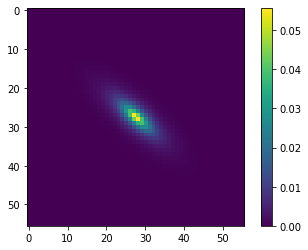

In [8]:
scale = 0.03 # in arcsec

#cosmos_cat = galsim.COSMOSCatalog()
gal = cosmos_cat.makeGalaxy(0, gal_type='parametric')
#gal = cosmos_cat.makeGalaxy(0)
gal_stepk = gal.stepk
gal_image = gal.drawImage(scale=scale)
print(gal_image.array.shape)
imshow(gal_image.array)
colorbar()

In [9]:
gal_tf = tf.convert_to_tensor(gal_image.array, tf.float32)

In [10]:
beta = 3.5
fwhm = .9
psf = galsim.Moffat(beta=beta, fwhm=.9)

psf_q = 0.025
psf_shape = galsim.Shear(q=psf_q, beta=0.*galsim.degrees)
psf.shear(psf_shape)

psf_stepk = psf.stepk
print(psf_stepk)
psf_image = psf.drawImage(scale=scale).array
psf_kimage = psf.drawKImage(scale=scale).array
print('psf_image:', psf_image.shape)
print('psf_kmage:', psf_kimage.shape)

1.1323142046204118
psf_image: (188, 188)
psf_kmage: (947, 947)


In [11]:
conv = galsim.Convolve([gal, psf])

In [12]:
def get_good_image_size(pixel_scale, stepk):
  """
  setpk is assumed to be known for a given profile
  """
  Nd = 2. * math.pi / (pixel_scale * stepk)

  # Make it an integer
  # (Some slop to keep from getting extra pixels due to roundoff errors in calculations.)
  N = int(math.ceil(Nd*(1.-1.e-12)))

  # Round up to an even value
  N = 2 * ((N+1) // 2)
  return N  

conv_stepk = 1/tf.math.sqrt(1/tf.math.pow(gal_stepk, 2) + 1/tf.math.pow(psf_stepk, 2))
N = get_good_image_size(scale, conv_stepk)
print(get_good_image_size(scale, conv_stepk))
print(gal.getGoodImageSize(pixel_scale=scale))

image_N = gal_image.array.shape[0]
N = max(N, image_N)
print(N)

194
54
194


In [13]:
"""
int goodFFTSize(int input)
{
if (input<=2) return 2;
// Reduce slightly to eliminate potential rounding errors:
double insize = (1.-1.e-5)*input;
double log2n = std::log(2.)*std::ceil(std::log(insize)/std::log(2.));
double log2n3 = std::log(3.)
    + std::log(2.)*std::ceil((std::log(insize)-std::log(3.))/std::log(2.));
log2n3 = std::max(log2n3, std::log(6.)); // must be even number
int Nk = int(std::ceil(std::exp(std::min(log2n, log2n3))-1.e-5));
return Nk;
"""
def good_fft_size(N):
  N = tf.convert_to_tensor(N, tf.float32)
  if N<=2:
    return 2
  else:
    insize = (1.-1.e-5)*N
    log2n = tf.math.log(2.) * tf.math.ceil(tf.math.log(N)/tf.math.log(2.))
    log2n3 = tf.math.log(3.) + tf.math.log(2.) * tf.math.ceil((tf.math.log(N)-tf.math.log(3.))/tf.math.log(2.))
    log2n3 = tf.reduce_max([log2n3, tf.math.log(6.)])
    Nk = tf.math.ceil(tf.math.exp(tf.reduce_min([log2n, log2n3])-1.e-5))
    return Nk

N = good_fft_size(N)
print(good_fft_size(N))
print(gal_image.good_fft_size(N))

tf.Tensor(256.0, shape=(), dtype=float32)
256


In [14]:
print(gal.gsparams.minimum_fft_size) # minimum and none is specified

N = tf.cast(tf.reduce_max([N, 128]), tf.float32)
print(N)

128
tf.Tensor(256.0, shape=(), dtype=float32)


In [15]:
# Fourier scale of target image

dk = 2.*_pi / (N * scale)
print(dk)

tf.Tensor(0.8181231, shape=(), dtype=float32)


In [16]:
# get maxk for each inpout
print('galsim')
print(gal._maxk)
print(psf._maxk)

gal_maxk = gal._maxk
psf_maxk = psf._maxk

conv_maxk = tf.reduce_min([gal_maxk, psf_maxk])
print(conv_maxk)

galsim
260.97069431559277
14.189052477454839
tf.Tensor(14.189053, shape=(), dtype=float32)


In [17]:
if N*dk/2 > conv_maxk:
  Nk = N
else:
  # There will be aliasing.  Make a larger image and then wrap it.
  Nk = int(np.ceil(conv_maxk/dk)) * 2
    
print(Nk)

assert Nk < gal.gsparams.maximum_fft_size

tf.Tensor(256.0, shape=(), dtype=float32)


In [18]:
from galsim.bounds import _BoundsI
from galsim.image import Image, ImageCF, ImageCD
bounds = _BoundsI(0,Nk//2,-Nk//2,Nk//2-1)
kimage = ImageCF(bounds=bounds, scale=dk)
print(bounds)

galsim.BoundsI(0,128,-128,127)


(56, 29)
(188, 95)


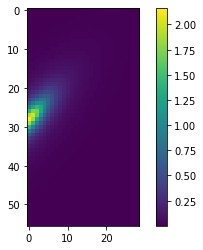

In [19]:
print(tf.signal.rfft2d(gal_image.array).shape)
print(tf.signal.rfft2d(psf_image).shape)

#imshow(abs(tf.signal.fftshift(tf.signal.rfft2d(gal_image.array), axes=0)))
imshow(abs(tf.signal.fftshift(tf.signal.rfft2d(tf.signal.fftshift(gal_image.array)), axes=0)))
colorbar()

(56, 29)


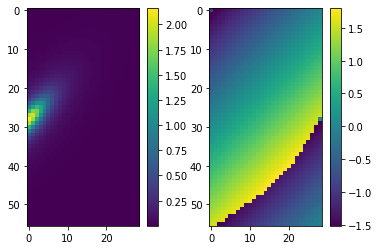

In [20]:
tf_gf = tf.signal.fftshift(tf.signal.rfft2d(tf.signal.fftshift(gal_image.array)), axes=0)
#tf_gf = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(tf.cast(gal_image.array, tf.complex64))), axes=0)

subplot(121)
imshow(tf.math.abs(tf_gf))
colorbar()
subplot(122)
imshow(tf.math.angle(tf_gf))
colorbar()

print(tf.math.abs(tf_gf).shape)

(56, 29)


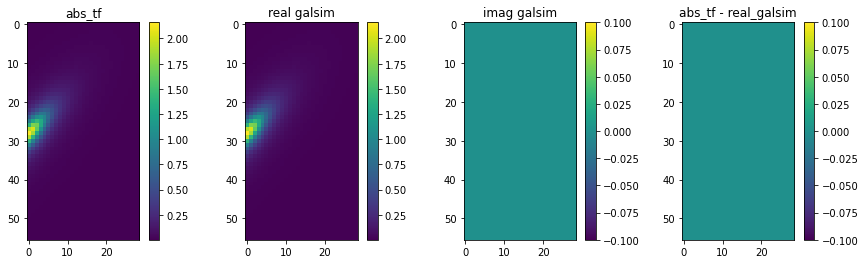

In [47]:
nk_test = 56
bounds_test = _BoundsI(0,nk_test//2,-nk_test//2,nk_test//2-1)
galsim_gal = gal.drawKImage(bounds=bounds_test, scale=2.*np.pi/(nk_test*scale), recenter=False).array
abs_sim = abs(galsim_gal)

figure(figsize=(15,4))
subplot(141)
imshow(abs_sim)
title('abs_tf')
colorbar()
print(abs_sim.shape)

subplot(142)
imshow(tf.math.real(galsim_gal))
title('real galsim')
colorbar()

subplot(143)
imshow(tf.math.imag(galsim_gal))
title('imag galsim')
colorbar()

subplot(144)
imshow(tf.math.real(galsim_gal) - abs_sim)
title('abs_tf - real_galsim')
colorbar()

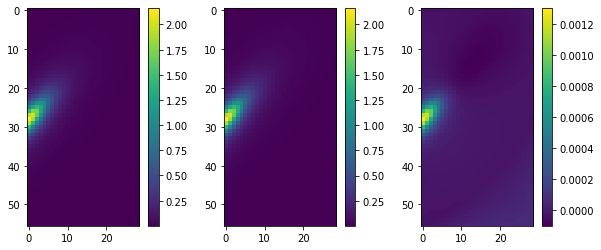

In [60]:
imk_tf = tf.signal.fftshift(tf.signal.rfft2d(tf.signal.fftshift(gal_image.array)), axes=0)
imk_real = tf.math.real(imk_tf)
imk_imag = tf.math.imag(imk_tf)
imk_test = tf.math.sqrt(imk_real**2 + imk_imag**2)

figure(figsize=(10,4))
subplot(131)
imshow(imk_test)
colorbar()
subplot(132)
imshow(tf.cast(tf.math.abs(galsim_gal), tf.float32))
colorbar()
subplot(133)
imshow(imk_test/tf.reduce_sum(imk_test) - tf.cast(tf.math.abs(galsim_gal)/tf.reduce_sum(tf.math.abs(galsim_gal)), tf.float32))
colorbar()

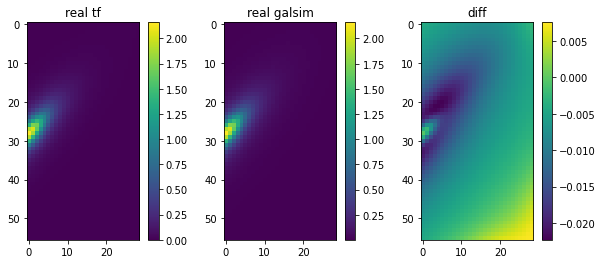

In [61]:
# comparing real part
real_gs = tf.math.real(gal.drawKImage(bounds=bounds_test, scale=2.*np.pi/(nk_test*scale), recenter=False).array)

figure(figsize=(10,4))
subplot(131)
imshow(imk_real)
title('real tf')
colorbar()
subplot(132)
imshow(real_gs)
title('real galsim')
colorbar()
subplot(133)
imshow(imk_real-tf.cast(real_gs, tf.float32))
title('diff')
colorbar()

In [63]:
bounds = _BoundsI(0,Nk//2,-Nk//2,Nk//2-1)

In [70]:
imk_gs = gal.drawKImage(bounds=bounds, scale=2.*np.pi/(Nk*scale), recenter=False).array
abs_sim = abs(imk_gs)

(256, 129)


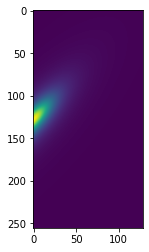

In [71]:
imshow(abs(abs_sim))
print(abs(abs_sim).shape)

Interpolate in the Fourier domain

(56, 29)


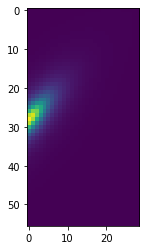

In [72]:
abs_gal = abs(tf.signal.fftshift(tf.signal.rfft2d(gal_image.array), axes=0))
imshow(abs_gal)
print(abs_gal.shape)

In [73]:
#abs_gal = tf.pad(abs_gal, paddings)
abs_gal = tf.reshape(abs_gal, (1,56,29,1))
print(abs_gal.shape)

(1, 56, 29, 1)


In [74]:
wrap = tf.expand_dims(tf.stack(tf.meshgrid(tf.linspace(1.,29.-1, 129), tf.linspace(0.,56.-1, 256)), axis=-1), 0)
wrap

<tf.Tensor: shape=(1, 256, 129, 2), dtype=float32, numpy=
array([[[[ 1.        ,  0.        ],
         [ 1.2109375 ,  0.        ],
         [ 1.421875  ,  0.        ],
         ...,
         [27.578125  ,  0.        ],
         [27.789062  ,  0.        ],
         [28.        ,  0.        ]],

        [[ 1.        ,  0.21568628],
         [ 1.2109375 ,  0.21568628],
         [ 1.421875  ,  0.21568628],
         ...,
         [27.578125  ,  0.21568628],
         [27.789062  ,  0.21568628],
         [28.        ,  0.21568628]],

        [[ 1.        ,  0.43137255],
         [ 1.2109375 ,  0.43137255],
         [ 1.421875  ,  0.43137255],
         ...,
         [27.578125  ,  0.43137255],
         [27.789062  ,  0.43137255],
         [28.        ,  0.43137255]],

        ...,

        [[ 1.        , 54.568626  ],
         [ 1.2109375 , 54.568626  ],
         [ 1.421875  , 54.568626  ],
         ...,
         [27.578125  , 54.568626  ],
         [27.789062  , 54.568626  ],
         [28.  

In [75]:
from galflow.python.tfutils.transformer import sample

In [77]:
interp = sample(abs_gal, wrap)

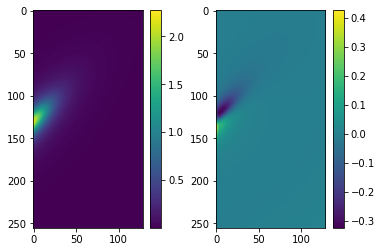

In [78]:
interp.shape
subplot(121)
imshow(interp[0,...,0])
colorbar()
subplot(122)
imshow((interp[0,...,0]-abs_sim))
colorbar()

In [79]:
# it looks like there is a little shift...

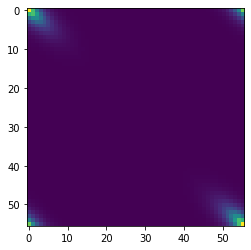

In [80]:
imshow(tf.signal.fftshift(gal_image.array))

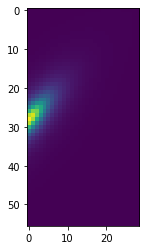

In [81]:
gal_cplx = tf.reshape(tf.signal.fftshift(tf.signal.rfft2d(tf.signal.fftshift(gal_image.array)), axes=0), (1,56,29,1))
imshow(abs(gal_cplx)[0,...,0])

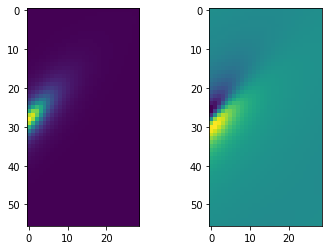

In [82]:
subplot(121)
imshow(tf.math.real((gal_cplx)[0,...,0]))
subplot(122)
imshow(tf.math.imag((gal_cplx)[0,...,0]))

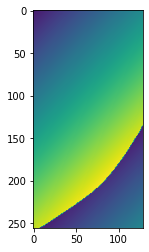

In [83]:
interp_real = sample(tf.math.real(gal_cplx), wrap)
interp_imag = sample(tf.math.imag(gal_cplx), wrap)
interp_cplx = tf.complex(interp_real, interp_imag)
#imshow(tf.math.abs(interp_cplx)[0,...,0])
imk_gf = interp_cplx[0,...,0]
imshow(tf.math.angle(imk_gf))

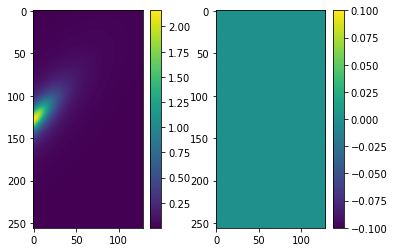

In [84]:
imk_gs = gal.drawKImage(bounds=bounds, scale=2.*np.pi/(Nk*scale), recenter=False).array
subplot(121)
imshow(tf.math.real(imk_gs))
colorbar()

subplot(122)
imshow(tf.math.imag(imk_gs))
colorbar()

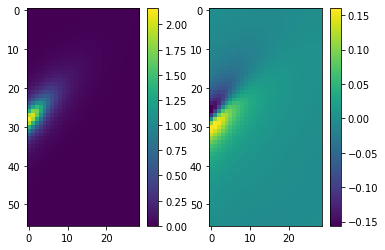

In [85]:
gal_f = tf.signal.fftshift(tf.signal.rfft2d(tf.signal.fftshift(gal_image.array)), axes=0)

subplot(121)
imshow(tf.math.real(gal_f))
colorbar()

subplot(122)
imshow(tf.math.imag(gal_f))
colorbar()

In [86]:
interp_real = sample(tf.expand_dims(tf.expand_dims(tf.math.real(gal_f), 0), -1), wrap)

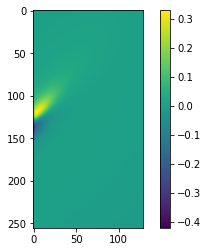

In [87]:
imshow(tf.cast(tf.math.real(imk_gs), tf.float32)-interp_real[0,...,0])
colorbar()